In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchbnn as bnn

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score as roc_auc_score
from torchmetrics.classification import BinaryCalibrationError

from scipy.stats import wasserstein_distance
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from BayesianSequentialNet import BayesianSequentialNet
from machine_learning import *
from util import *


In [2]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
def word_to_int(df):
    # Red = 0, blue = 1
    df["class"] = 0
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 1
    return df

def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [4]:
# Set up device
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(0)}")

Using cuda:0 device NVIDIA TITAN V


In [5]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
load_values = True
save_values = False

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nr1MC_4000"
truthfile_test = "analytical_solution_test_n_10000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_nr1MC_8000"
gridfile = f"x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2] # Remove undefined area
truth_test_data = pd.read_csv(f"../analytical/results/{truthfile_test}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

# Prepare data for pytorch
train_data = word_to_int(train_data)
val_data = word_to_int(val_data)
test_data = word_to_int(test_data)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

In [6]:
# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)

In [7]:
# Learning rate is very important

#1 hidden layer, nodes=200
# n_train = 250, epochs=250, lr=0.01, batchsize=250
# n_train=1500, epochs=180, lr=0.01, batchsize=2**9
# n_train = 2000, epochs=140, lr=0.05, batchsize=2**9
# n_train = 5000, epochs=180, lr=0.01, batchsize=2**9
# n_train = 10000, epochs=180, lr=0.01, batchsize=2**10

#2 hidden layers, nodes=100
# n_train = 250, epochs=100, lr=0.028, bs=128 
# n_train = 1000, epochs=134, lr=0.03, bs=512
# n_train = 5000, epochs=100, lr=0.045, bs=1024
# n_train = 10000, epochs = 150, lr=0.05, bs = 1024
#n_data = [250, 5000, 10000]
n_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
        
test_dfs = [0]*len(n_data)
grid_dfs = [0]*len(n_data)

val_df = pd.read_csv(f"../data/{valfile}.csv")
test_df = pd.read_csv(f"../data/{testfile}.csv")
grid_df = pd.read_csv(f"../data/{gridfile}.csv")


In [8]:

#lr_list = [0.028, 0.02, 0.05]#np.linspace(0.01, 0.1, 10)
lr_list = [0.028, 0.028, 0.03, 0.04, 0.05, 0.05, 0.05]
bs_list = [128, 128, 128*2, 128*2, 1024, 1024, 1024*2]
#epochs_list = [1000, 180, 180]
epochs_list = [100]*len(n_data)
patience_list = [50, 50, 30, 30, 30, 30, 30]
nodes = 200
hidden_layers = 2

100%|██████████| 20/20 [00:01<00:00, 14.41it/s]


n_train = 1000, lr=0.03, logloss=0.5481372958206592, ECE= 0.050410911440849304


(0.0, 2.0)

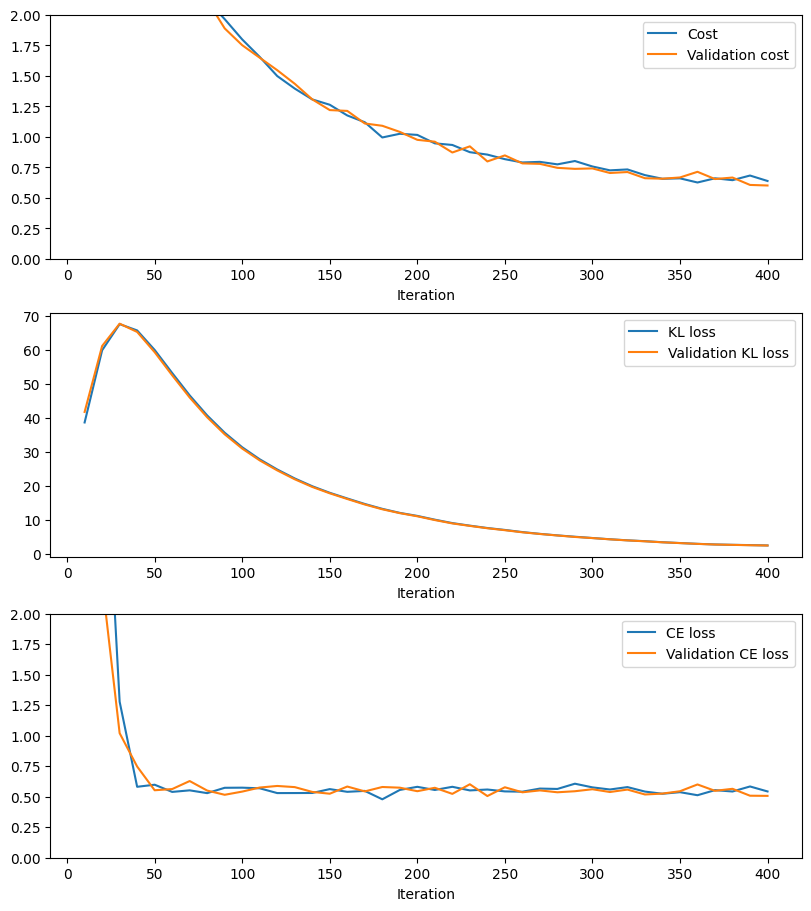

In [9]:
i = 2
n_train = n_data[i]
epochs = epochs_list[i]
batchsize = bs_list[i]
logloss_min = 1 #Minimize this
#ece_min = 1
lr = lr_list[i]
#best_lr = 100

model = BayesianSequentialNet(L=nodes, n_hidden=hidden_layers, activation="relu", in_channels=2, out_channels=2,
                                sigmaprior=0.01).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_dataset_small = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])
train_results = train_bnn_classifier(model, train_dataset_small, val_dataset, batchsize, 
                                    epochs, device, optimizer, early_stopping=patience_list[i])

val_df = predict_bnn(model, val_dataset, val_df, device, n_samples=20)
ll = log_loss(val_df["class"], val_df["Est_prob_blue"])
preds = torch.Tensor(val_df["Est_prob_blue"])
target = torch.Tensor(val_df["class"])
bce_l1 = BinaryCalibrationError(n_bins=15, norm='l1')
ece = bce_l1(preds, target).item()
print(f"n_train = {n_train}, lr={lr}, logloss={ll}, ECE= {ece}")

fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 3*3), layout="constrained")
train_results.plot("Iteration", ["Cost", "Validation cost"], ax=axs[0])
axs[0].set_ylim(0, 2)
train_results.plot("Iteration", ["KL loss", "Validation KL loss"], ax=axs[1])
train_results.plot("Iteration", ["CE loss", "Validation CE loss"], ax=axs[2])
axs[2].set_ylim(0, 2)


In [10]:
test_df = predict_bnn(model, test_dataset, test_data, device, n_samples=20)
grid_df = predict_bnn(model, grid_dataset, grid_data, device, n_samples=20)

100%|██████████| 20/20 [00:02<00:00,  7.16it/s]


Text(0.5, 0.98, 'Number of training datapoints: 1000')

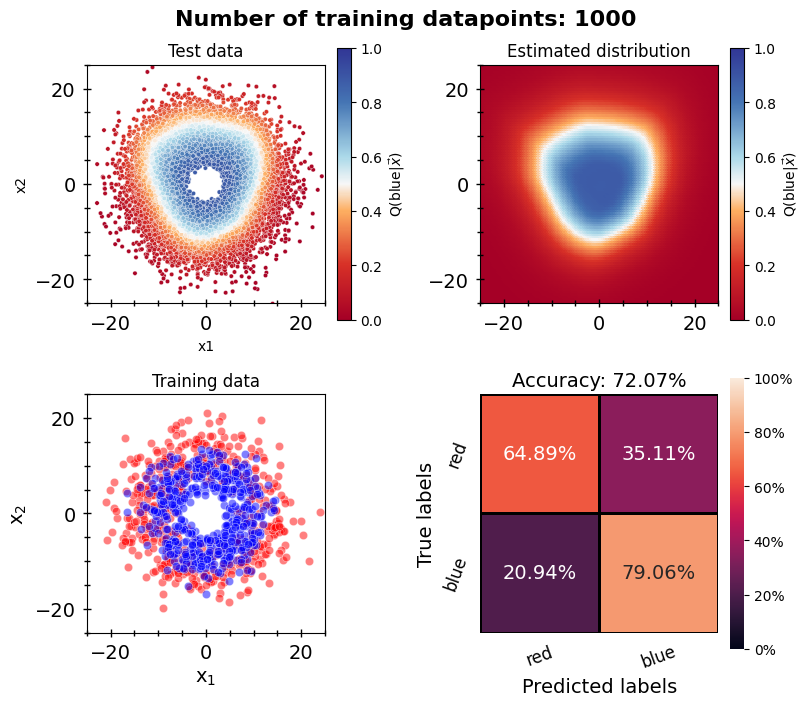

In [11]:

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(test_df, "Est_prob_blue", axs[0][0], "Test data", error_key="Std_prob_blue")
axs[0][1] = plot_results(grid_df, "Est_prob_blue", axs[0][1], "Estimated distribution", grid=True)
axs[1][1] = plot_conf_matrix(test_df, "class", "Prediction", ["red", "blue"], axs[1][1])
axs[1][0] = plot_data(train_data[0:n_train], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

fig.suptitle(f"Number of training datapoints: {n_train}", size=16, fontweight="bold")


Text(0.5, 0.98, 'Number of training datapoints: 1000')

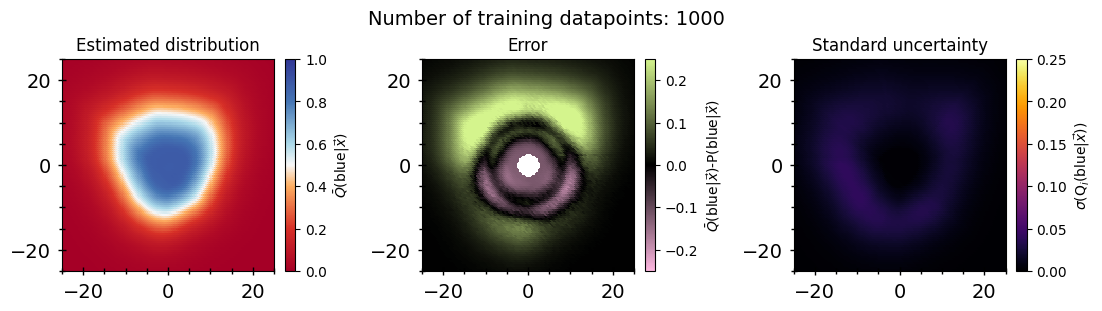

In [12]:

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
axs[0] = plot_results(grid_df, "Est_prob_blue", axs[0], "Estimated distribution", grid=True)
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()),  fraction=0.050, pad=0.04,
                label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0])

axs[1] = plot_diff(grid_df, truth_data, "Est_prob_blue", "P_blue_given_x", axs[1], r"Error", max_val=max_err_val[i])
hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()),  fraction=0.050, pad=0.04,
                label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1])

axs[2] = plot_std(grid_df, "Std_prob_blue", axs[2], "Standard uncertainty", grid=True, max_val=max_err_val[i])

hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"),  fraction=0.050, pad=0.04,
                label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2])

fig.suptitle(f"Number of training datapoints: {n_train}", fontsize=14)
#fig.savefig(f"../fig/BNN_ntrain_{n_train}.pdf", format="pdf", bbox_inches='tight', dpi=350)


In [13]:
scores = calculate_metrics([test_df], [grid_df], [n_train], truth_data, truth_test_data, 
                           "Prediction", "Est_prob_blue", "Std_prob_blue")
print(scores)

   N data       ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0    1000  0.720672  0.800926  0.058046  0.062463  0.023297  0.009843   

   Mean KL-div test  Mean KL-div grid   LogLoss      ECE      MCE     RMSCE  
0          0.027499          0.030123  0.544762  0.03781  0.11154  0.049722  


Text(0.5, 0.98, 'Number of datapoints: 1000')

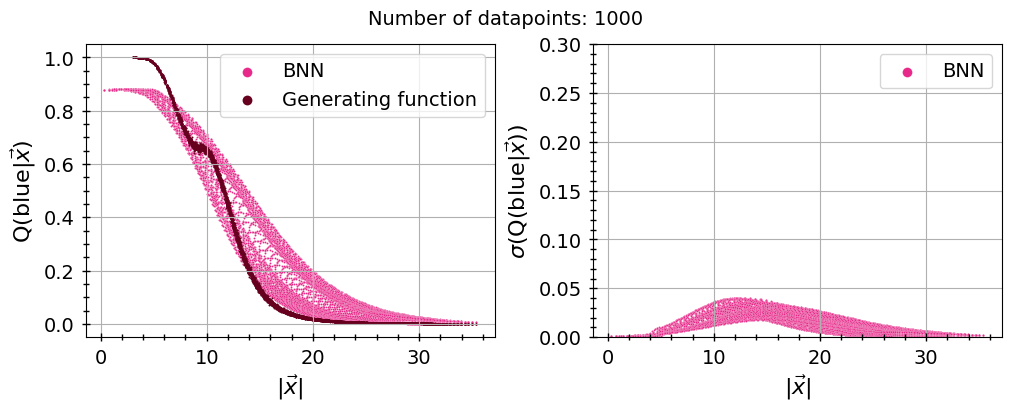

In [14]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
sn.scatterplot(grid_df, x="r_x", y="Est_prob_blue", s=2, ax = axs[0], label="BNN", color="#e7298a")
sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function", color="#67001f", linewidth=0)
axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

sn.scatterplot(grid_df, x="r_x", y="Std_prob_blue", s=2, ax = axs[1], label="BNN", color="#e7298a")
axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
axs[1].set_ylim(0, 0.3)

for ax in axs:
    ax.legend(markerscale=5, fontsize=14)
    ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.grid()
fig.suptitle(f"Number of datapoints: {n_train}", fontsize=14)

Text(0.5, 0.98, 'Number of training datapoints: 1000')

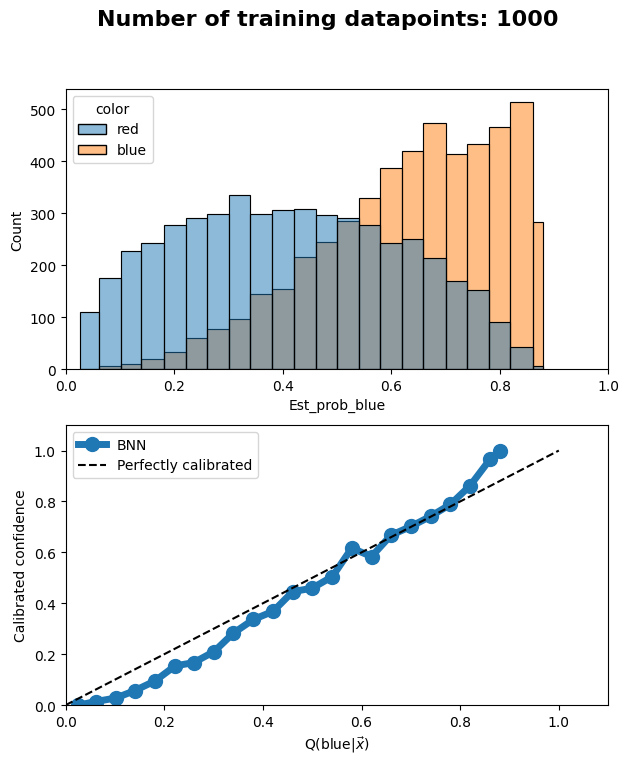

In [15]:

prob_cal, prob_pred = calibration_curve(test_df["class"], test_df["Est_prob_blue"], n_bins=25, strategy="uniform")
pred_bins=list(prob_pred)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
sn.histplot(test_df, x="Est_prob_blue", hue="color", ax=ax[0], stat="count", bins=pred_bins)
ax[0].set_xlim(0,1)
ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="BNN")
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(0,1.1)
x = np.linspace(0, 1, 10)
ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
ax[1].set_xlabel(r"Q(blue|$\vec{x}$)")
ax[1].set_ylabel("Calibrated confidence")
ax[1].legend()
fig.suptitle(f"Number of training datapoints: {n_train}", size=16, fontweight="bold")